# Aula 10: Análise de Sentimentos usando auto-atenção
Nome: **Orlem Lima dos Santos**

Neste notebook iremos treinar um modelo para fazer análise de sentimento usando o dataset IMDB.

# Auto-atenção (com pre-treino)

In [ ]:
# !pip install pytorch_lightning==1.2.10
# !pip install neptune-client
# ##!pip install fairseq

In [ ]:
version = "large_selfatt_embed_posembed_test2" #@param {type: "string"}
lr = 1e-2#@param {type: "number"}
# lr = 0.0025118864315095807#@param {type: "number"}
embed_lr = 1e-5#@param {type: "number"}
w_decay = 0#@param {type: "number"}
bs = 64#@param {type: "integer"}
accum_grads = 1#@param {type: "integer"}
patience = 50#@param {type: "integer"}
max_epochs = 200#@param {type: "integer"}
hidden_dim = 100#@param {type: "raw"}
drop_rate = 0.1#@param {type: "number"}
drop_rate_emb = 0.1#@param {type: "number"}
freeze = False #@param {type: "boolean"}
seq_len = 1024#@param {type: "raw"}
positional_embedding_type =  'embed'#@param {type: "raw"}
# 'sin', 'embed', None
loop = False#@param {type: "boolean"}
attn_dropout = 0.01#@param {type: "number"}
temperature = 100#@param {type: "integer"}

# Define hyperparameters
hparams = {"version": version,
          "lr": lr,
          "embed_lr": embed_lr,
          "w_decay": w_decay,
          "bs": bs, 
          "patience": patience,
          "accum_grads": accum_grads,
          "hidden_dim": hidden_dim,
          "drop_rate": drop_rate,
          "drop_rate_emb": drop_rate_emb,
          "freeze": freeze,
          "loop": loop,
          "attn_dropout": attn_dropout,
          "temperature": temperature, 
          "max_epochs": max_epochs}
hparams

{'accum_grads': 1,
 'attn_dropout': 0.01,
 'bs': 64,
 'drop_rate': 0.1,
 'drop_rate_emb': 0.1,
 'embed_lr': 1e-05,
 'freeze': False,
 'hidden_dim': 100,
 'loop': False,
 'lr': 0.01,
 'max_epochs': 200,
 'patience': 50,
 'temperature': 100,
 'version': 'large_selfatt_embed_posembed_test2',
 'w_decay': 0}

# Preparando Dados

In [ ]:
from pytorch_lightning.loggers.neptune import NeptuneLogger

In [ ]:
neptune_logger = NeptuneLogger(
    api_key="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJjMmJkZTg1Yy1kMjQ1LTRmMjEtYjBmYy1kMjVlMmMxODcyMTgifQ==",
    project_name='orllem/Aula10Imdb')

NeptuneLogger will work in online mode


Primeiro, fazemos download do dataset:

In [ ]:
!wget -nc http://files.fast.ai/data/examples/imdb_sample.tgz
!tar -xzf imdb_sample.tgz

--2021-06-09 21:29:04--  http://files.fast.ai/data/examples/imdb_sample.tgz
Resolving files.fast.ai (files.fast.ai)... 104.26.2.19, 172.67.69.159, 104.26.3.19, ...
Connecting to files.fast.ai (files.fast.ai)|104.26.2.19|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://files.fast.ai/data/examples/imdb_sample.tgz [following]
--2021-06-09 21:29:04--  https://files.fast.ai/data/examples/imdb_sample.tgz
Connecting to files.fast.ai (files.fast.ai)|104.26.2.19|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 571827 (558K) [application/x-gtar-compressed]
Saving to: ‘imdb_sample.tgz’

imdb_sample.tgz     100%[===================>] 558.42K   845KB/s    in 0.7s    

2021-06-09 21:29:05 (845 KB/s) - ‘imdb_sample.tgz’ saved [571827/571827]



In [ ]:
# from fairseq.optim import adafactor
import nvidia_smi
import pytorch_lightning as pl
from torch.utils.data import DataLoader
import torch
from torch import nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torchmetrics.functional import f1
from torchmetrics.functional import accuracy
import os
from google.colab import drive
import numpy as np
import itertools
import time

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
print(f"Pytorch Lightning Version: {pl.__version__}")
nvidia_smi.nvmlInit()
handle = nvidia_smi.nvmlDeviceGetHandleByIndex(0)
print(f"Device name: {nvidia_smi.nvmlDeviceGetName(handle)}")

Pytorch Lightning Version: 1.2.10
Device name: b'Tesla P100-PCIE-16GB'


Carregamos o dataset .csv usando o pandas:

In [ ]:
import pandas as pd
df = pd.read_csv('imdb_sample/texts.csv')
df.shape
df.head()

,label,text,is_valid
0,negative,Un-bleeping-believable! Meg Ryan doesn't even ...,False
1,positive,This is a extremely well-made film. The acting...,False
2,negative,Every once in a long while a movie will come a...,False
3,positive,Name just says it all. I watched this movie wi...,False
4,negative,This movie succeeds at being one of the most u...,False


Iremos agora dividir o dataset em conjuntos de treino e teste:

In [ ]:
# treino = df[df['is_valid'] == False]
test = df[df['is_valid'] == True]

# print('treino.shape:', treino.shape)
print('test.shape:', test.shape)

test.shape: (200, 3)


E iremos dividir estes dois conjuntos em entrada (X) e saída desejada (Y, ground-truth) do modelo:

In [ ]:
# X_treino = treino['text']
# Y_treino = treino['label']
X_test = test['text']
Y_test = test['label']

# print('X_treino.head():', X_treino.head())
# print('Y_treino.head():', Y_treino.head())

print('X_test.head():', X_test.head())
print('Y_test.head():', Y_test.head())

X_test.head(): 800    This very funny British comedy shows what migh...
801    I saw this movie once as a kid on the late-lat...
802    This is, in my opinion, a very good film, espe...
803    In Iran, women are not permitted to attend men...
804    "In April 1946, the University of Chicago agre...
Name: text, dtype: object
Y_test.head(): 800    positive
801    positive
802    positive
803    positive
804    positive
Name: label, dtype: object


In [ ]:
from torchtext.datasets import IMDB

train_iter = IMDB(split='train')

aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:05<00:00, 15.3MB/s]


In [ ]:
print(len(train_iter))

train_label, train_line = [],[]
for label, line in train_iter:
  train_label.append(label)
  train_line.append(line)

print(train_label[0:5])
print(train_line[0:5])

25000
['neg', 'neg', 'neg', 'neg', 'neg']
['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex an

In [ ]:
X_treino = train_line.copy()
Y_treino = pd.DataFrame(train_label)

In [ ]:
print(X_treino[0:5])
print(len(X_treino[0:5]))
print('Y_traino.head():', Y_treino.head())

['I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between, e

Ainda falta converter as strings "positive" e "negative" do ground-truth para valores booleanos:

In [ ]:
mapeamento = {'positive': True, 'negative': False}
Y_test = Y_test.map(mapeamento)
print(Y_test.head())

mapeamento_train = {'pos': True, 'neg': False}
Y_treino_bool = Y_treino[0].map(mapeamento_train)
print(Y_treino_bool.head())

800    True
801    True
802    True
803    True
804    True
Name: label, dtype: bool
0    False
1    False
2    False
3    False
4    False
Name: 0, dtype: bool


In [ ]:
df['text']

0      Un-bleeping-believable! Meg Ryan doesn't even ...
1      This is a extremely well-made film. The acting...
2      Every once in a long while a movie will come a...
3      Name just says it all. I watched this movie wi...
4      This movie succeeds at being one of the most u...
                             ...                        
995    There are many different versions of this one ...
996    Once upon a time Hollywood produced live-actio...
997    Wenders was great with Million $ Hotel.I don't...
998    Although a film with Bruce Willis is always wo...
999    A compelling, honest, daring, and unforgettabl...
Name: text, Length: 1000, dtype: object

In [ ]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X_treino, Y_treino_bool.values,
                                                      test_size=0.15, stratify=Y_treino_bool.values,
                                                      random_state=12)

In [ ]:
print(X_train[0:5])
print(Y_train[0:5])

['EARTH (2009) ***1/2 Big screen adaptation of the BBC/Discovery Channel series "Planet Earth" offers quite a majestic sampling of nature in all its beauty with some truly jaw-dropping moments of "how the hell did they get this footage?!" while taking in the awesome scenics of animals in their natural habitats and environmental message of the circle of life can be cruel (witness a Great White Shark gulping down a walrus seal as a quick meal!) and adorable (the various babies and their \'rents). The basso profundo tones of narrator James Earl Jones solidifies its \'God\'s eye views\' and profundity. Culled from literally hundreds of hours of footage, the only gripe comes from the fact this should have been in the IMAX format and could\'ve even gone longer! Oh, well, there\'s always the next time (since Disney Studios has produced this count on a series of more to come). Dirs: Alastair Fothergill & Mark Linfield.', 'I really liked this film when it was released, and I still do, because t

In [ ]:
print(X_valid[0:5])
print(Y_valid[0:5])

["First of all, the big named actors must need the money... The surgical scenes were laughable.... and surely they must know that people who have a little knowledge of medicine would find this utterly absurd......Anesthesiologists do not leave the room during a heart transplant....nor do they do the surgery in a tiny room devoid of instruments, heart lung equipment and sterile techniques... just a joke... couldn't concentrate on the story line because of all the stupid surgery scenes... no blood, no personnel and then the hero doc coming in and taking over... it is not a film for thinking adults....Also the budget must have been limited... the street scenes were OK but who was the technical adviser....Seems like it was directed by a total idiot.. Save your money and wait until it comes out on DVD and Don't rent it..", 'After perusing the large amount of comments on this movie it is clear that there are two kinds of science fiction movie-goers. There are the ones who are well read, extr

In [ ]:
print(X_test[0:5].values)
print(Y_test[0:5].values)

["This very funny British comedy shows what might happen if a section of London, in this case Pimlico, were to declare itself independent from the rest of the UK and its laws, taxes & post-war restrictions. Merry mayhem is what would happen.<br /><br />The explosion of a wartime bomb leads to the discovery of ancient documents which show that Pimlico was ceded to the Duchy of Burgundy centuries ago, a small historical footnote long since forgotten. To the new Burgundians, however, this is an unexpected opportunity to live as they please, free from any interference from Whitehall.<br /><br />Stanley Holloway is excellent as the minor city politician who suddenly finds himself leading one of the world's tiniest nations. Dame Margaret Rutherford is a delight as the history professor who sides with Pimlico. Others in the stand-out cast include Hermione Baddeley, Paul Duplis, Naughton Wayne, Basil Radford & Sir Michael Hordern.<br /><br />Welcome to Burgundy!"
 "I saw this movie once as a k

## Carregando os word embeddings com gensim

Usamos o gensim para fazer download e carregar os word embeddings. Lista dos modelos disponíveis: https://github.com/RaRe-Technologies/gensim-data#models

In [ ]:
import gensim.downloader as api

word2vec_model = api.load("glove-wiki-gigaword-300")
print(word2vec_model.vectors.shape)

[==================================================] 100.0% 376.1/376.1MB downloaded
(400000, 300)


In [ ]:
print(word2vec_model.index2word)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
embeddings = np.vstack((word2vec_model.vectors,[0]*word2vec_model.vectors.shape[1]))
embeddings = torch.FloatTensor(embeddings)

print(embeddings.shape)

torch.Size([400001, 300])


In [ ]:
embeddings[0:5]

tensor([[ 0.0466,  0.2132, -0.0074,  ...,  0.0091, -0.2099,  0.0539],
        [-0.2554, -0.2572,  0.1317,  ..., -0.2329, -0.1223,  0.3550],
        [-0.1256,  0.0136,  0.1031,  ..., -0.3422, -0.0224,  0.1368],
        [-0.0769, -0.0212,  0.2127,  ...,  0.1835, -0.2918, -0.0465],
        [-0.2576, -0.0571, -0.6719,  ..., -0.1604,  0.0467, -0.0706]])

## Criando Vocabulário a partir do word embedding

In [ ]:
vocab = {word: index for index, word in enumerate(word2vec_model.index2word)}

# Adicionar pad token
vocab['[PAD]'] = len(vocab)
pad_vector = np.zeros((1, word2vec_model.vectors.shape[1]))

print('Número de palavras no vocabulário:', len(vocab))
print(f'20 tokens mais frequentes: {list(itertools.islice(vocab.keys(), 20))}')

Número de palavras no vocabulário: 400001
20 tokens mais frequentes: ['the', ',', '.', 'of', 'to', 'and', 'in', 'a', '"', "'s", 'for', '-', 'that', 'on', 'is', 'was', 'said', 'with', 'he', 'as']


## Tokenizando o dataset e convertendo para índices

In [ ]:
import re

def tokenize(text):
  token = re.sub('[^a-zA-Z0-9 \\\]', ' ', text).split()
  return token

def tokens_to_ids(tokens, vocab):
  text = tokenize(tokens)
  token = [vocab[token] if token in vocab else vocab['unknown']  for token in text]
  token = list(filter((vocab['unknown']).__ne__, token))
  return token

def tokens_to_ids_batch(texts, vocab):
  batch_token = [tokens_to_ids(i, vocab) for i in texts]
  return batch_token

X_train_indices = tokens_to_ids_batch(X_train, vocab)
X_valid_indices = tokens_to_ids_batch(X_valid, vocab)
X_test_indices = tokens_to_ids_batch(X_test.values, vocab)

print('First exemple:')
print(X_train[0])
print(X_train_indices[0])
print(Y_train[0])

First exemple:
EARTH (2009) ***1/2 Big screen adaptation of the BBC/Discovery Channel series "Planet Earth" offers quite a majestic sampling of nature in all its beauty with some truly jaw-dropping moments of "how the hell did they get this footage?!" while taking in the awesome scenics of animals in their natural habitats and environmental message of the circle of life can be cruel (witness a Great White Shark gulping down a walrus seal as a quick meal!) and adorable (the various babies and their 'rents). The basso profundo tones of narrator James Earl Jones solidifies its 'God's eye views' and profundity. Culled from literally hundreds of hours of footage, the only gripe comes from the fact this should have been in the IMAX format and could've even gone longer! Oh, well, there's always the next time (since Disney Studios has produced this count on a series of more to come). Dirs: Alastair Fothergill & Mark Linfield.
[703, 176, 232, 2491, 7175, 3, 0, 281, 1728, 1689, 7, 19158, 11647, 

## Criar o embeddings

In [ ]:
NUM_LABELS = 2
labels = {False: 0, True: 1}

In [ ]:
def make_target(label, labels):
    return torch.LongTensor([labels[label]])

In [ ]:
class ImdbDataset(torch.utils.data.Dataset):

  def __init__(self, X, y, labels):
    self.X = X
    self.y = y
    self.labels = labels

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    vec = self.X[idx]
    target = make_target(self.y[idx], self.labels)[0]
    return vec, target

In [ ]:
train_dataset = ImdbDataset(X_train_indices, Y_train, 
                               labels=labels)
val_dataset = ImdbDataset(X_valid_indices, Y_valid, 
                             labels=labels)
test_dataset = ImdbDataset(X_test_indices, Y_test.values,
                              labels=labels)

In [ ]:
print('Número de amostras de trenamento:', len(train_dataset))
print('Número de amostras de validação:', len(val_dataset))
print('Número de amostras de teste:', len(test_dataset))

Número de amostras de trenamento: 21250
Número de amostras de validação: 3750
Número de amostras de teste: 200


In [ ]:
data = train_dataset[0]
print(data)
x = data[0]
y = data[1]
print('x:', x)
print('y:', y)

([703, 176, 232, 2491, 7175, 3, 0, 281, 1728, 1689, 7, 19158, 11647, 3, 1746, 6, 64, 47, 4282, 17, 77, 4702, 13277, 5014, 4039, 3, 197, 0, 5613, 119, 39, 169, 37, 5574, 110, 582, 6, 0, 13602, 3, 2430, 6, 44, 1132, 11150, 5, 1697, 1443, 3, 0, 4012, 3, 214, 86, 30, 9827, 3499, 7, 98128, 135, 7, 45997, 5874, 19, 7, 2582, 6858, 5, 35946, 0, 917, 6324, 5, 44, 15076, 26539, 166780, 13713, 3, 12684, 73504, 47, 1534, 2090, 2320, 5, 98324, 25, 5917, 1150, 3, 606, 3, 5574, 0, 91, 45956, 934, 25, 0, 853, 37, 189, 33, 51, 6, 0, 3488, 5, 94, 37138, 151, 1527, 1078, 143, 63, 1534, 690, 0, 182, 79, 108, 31, 1014, 37, 2428, 13, 7, 281, 3, 56, 4, 326], tensor(1))
x: [703, 176, 232, 2491, 7175, 3, 0, 281, 1728, 1689, 7, 19158, 11647, 3, 1746, 6, 64, 47, 4282, 17, 77, 4702, 13277, 5014, 4039, 3, 197, 0, 5613, 119, 39, 169, 37, 5574, 110, 582, 6, 0, 13602, 3, 2430, 6, 44, 1132, 11150, 5, 1697, 1443, 3, 0, 4012, 3, 214, 86, 30, 9827, 3499, 7, 98128, 135, 7, 45997, 5874, 19, 7, 2582, 6858, 5, 35946, 0, 917,

## Transformando word ids em batches

In [ ]:
# seq_len = # max_position_embeddings=seq_len
if positional_embedding_type!=None:
  max_position_embeddings = seq_len
else:
  max_position_embeddings = None 

print('max_position_embeddings:', max_position_embeddings)

d_word_vec = embeddings.shape[1] # hidden_size=d_word_vec
print('d_word_vec:', d_word_vec)

max_position_embeddings: 1024
d_word_vec: 300


In [ ]:
def truncate_and_pad(batch_word_ids, pad_token_id, seq_length=64):
    # Truncate.
    batch_word_ids = [word_ids[:seq_length] for word_ids in batch_word_ids]

    # Create mask.
    mask = [[1] * len(word_ids) + [0] * (seq_length - len(word_ids))
        for word_ids in  batch_word_ids]

    # Pad.
    batch_word_ids = [word_ids + [pad_token_id] * (seq_length - len(word_ids))
        for word_ids in batch_word_ids]

    return batch_word_ids, mask

texts = ['we like pizza', 'he does not like apples']
batch_word_ids = tokens_to_ids_batch(texts, vocab)
print('batch_word_ids', batch_word_ids)
batch, mask = truncate_and_pad(batch_word_ids=batch_word_ids,
                 pad_token_id=vocab['[PAD]'],
                 seq_length=64)

batch = np.array(batch)
mask = np.array(mask)
print('batch', batch)
print('mask', mask)
print('batch.shape:', batch.shape)
print('mask.shape:', mask.shape)

batch_word_ids = torch.from_numpy(
     np.array(batch, dtype=np.int64))
mask = torch.from_numpy(np.array(mask, dtype=np.float32))

batch_word_ids [[53, 117, 9388], [18, 260, 36, 117, 13134]]
batch [[    53    117   9388 400000 400000 400000 400000 400000 400000 400000
  400000 400000 400000 400000 400000 400000 400000 400000 400000 400000
  400000 400000 400000 400000 400000 400000 400000 400000 400000 400000
  400000 400000 400000 400000 400000 400000 400000 400000 400000 400000
  400000 400000 400000 400000 400000 400000 400000 400000 400000 400000
  400000 400000 400000 400000 400000 400000 400000 400000 400000 400000
  400000 400000 400000 400000]
 [    18    260     36    117  13134 400000 400000 400000 400000 400000
  400000 400000 400000 400000 400000 400000 400000 400000 400000 400000
  400000 400000 400000 400000 400000 400000 400000 400000 400000 400000
  400000 400000 400000 400000 400000 400000 400000 400000 400000 400000
  400000 400000 400000 400000 400000 400000 400000 400000 400000 400000
  400000 400000 400000 400000 400000 400000 400000 400000 400000 400000
  400000 400000 400000 400000]]
mask [[

# Definindo Dataset e dataloaders

In [ ]:
def collate_fn(batch):
    words_id_list, labels_list= zip(*batch)  
    batch_word_ids, mask = truncate_and_pad(batch_word_ids=words_id_list,
                 pad_token_id=vocab['[PAD]'],
                 seq_length=seq_len)  
    return torch.LongTensor(batch_word_ids), torch.LongTensor(mask), torch.LongTensor(labels_list)

In [ ]:
batch_size = hparams["bs"]

train_dataloader = DataLoader(train_dataset, batch_size=batch_size,
                              collate_fn=collate_fn,
                              shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size,
                            collate_fn=collate_fn,
                            shuffle=False,  num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size,
                             collate_fn=collate_fn,
                             shuffle=False,  num_workers=4)

print('Número de minibatches de trenamento:', len(train_dataloader))
print('Número de minibatches de validação:', len(val_dataloader))
print('Número de minibatches de teste:', len(test_dataloader))


x_train, train_mask, y_train = next(iter(train_dataloader))
x_valid, valid_mask, y_valid = next(iter(val_dataloader))
x_test, test_mask, y_test = next(iter(test_dataloader))
print("\nDimensões dos dados de um minibatch:", x_train.size())
print("\nDimensões dos dados de um minibatch:", x_valid.size())
print("\nDimensões dos dados de um minibatch:", x_test.size())
print("\nDimensões dos dados de um minibatch:", y_train.size())
print("Valores mínimo e máximo dos x: ", torch.min(x_train), torch.max(x_train))
print("Valores mínimo e máximo dos y: ", torch.min(y_train), torch.max(y_train))
print("Tipo dos dados das imagens:         ", type(x_train))
print("Tipo das classes das imagens:       ", type(y_train))

Número de minibatches de trenamento: 333
Número de minibatches de validação: 59
Número de minibatches de teste: 4

Dimensões dos dados de um minibatch: torch.Size([64, 1024])

Dimensões dos dados de um minibatch: torch.Size([64, 1024])

Dimensões dos dados de um minibatch: torch.Size([64, 1024])

Dimensões dos dados de um minibatch: torch.Size([64])
Valores mínimo e máximo dos x:  tensor(0) tensor(400000)
Valores mínimo e máximo dos y:  tensor(0) tensor(1)
Tipo dos dados das imagens:          <class 'torch.Tensor'>
Tipo das classes das imagens:        <class 'torch.Tensor'>


# Definindo o Classificador word2vec

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_hid, n_position=200):
        super(PositionalEncoding, self).__init__()

        # Not a parameter
        self.register_buffer('pos_table', self._get_sinusoid_encoding_table(n_position, d_hid))

    def _get_sinusoid_encoding_table(self, n_position, d_hid):
        ''' Sinusoid position encoding table '''
        # TODO: make it with torch instead of numpy

        def get_position_angle_vec(position):
            return [position / np.power(10000, 2 * (hid_j // 2) / d_hid) for hid_j in range(d_hid)]

        sinusoid_table = np.array([get_position_angle_vec(pos_i) for pos_i in range(n_position)])
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()

In [ ]:
class ScaledDotProductAttention(nn.Module):
    ''' Scaled Dot-Product Attention '''

    def __init__(self, temperature, attn_dropout=0.1):
        super().__init__()
        self.temperature = temperature
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask=None):
         # q=k=v.shape = (B, L, D) e mask.shape = (B, L).

        attn = torch.matmul(q / self.temperature, k.transpose(2, 1)) # B,L,L

        if mask is not None:
            mask = mask.unsqueeze(2)
            mask = mask.expand(mask.shape[0], mask.shape[1], mask.shape[1])
            attn = attn.masked_fill(mask == 0, -1e9)

        attn = self.dropout(F.softmax(attn, dim=-1)) # B,L,L
        output = torch.matmul(attn, v) # shape = B,L,D

        return output, attn

In [ ]:
import gensim
import torch.optim as optim

class SelfAttentionNN(nn.Module):
    def __init__(self, num_labels,
                 embeddings,
                 hidden_size,
                 pad_token_id,
                 hidden_dim = 100,
                 positional_embedding_type='sin',
                 max_position_embeddings=512,
                 loop=False):
      
        super().__init__()
        self.loop = loop
        self.loop_values = []

        self.embeddings = nn.Embedding.from_pretrained(embeddings,
                                                       padding_idx=pad_token_id,
                                                       freeze=hparams['freeze'])
        
        # whether to apply positional embeddings or not
        self.positional_embedding_type = positional_embedding_type
        if positional_embedding_type=='embed':
          self.position_embeddings = nn.Embedding(max_position_embeddings, hidden_size)
          self.register_buffer("position_ids", torch.arange(max_position_embeddings).expand((1, -1)))
          
          print('using positional_embedding_type:', str(positional_embedding_type))
          print('using max_position_embeddings:', str(max_position_embeddings))
        elif positional_embedding_type=='sin':
          print('using positional_embedding_type:', str(positional_embedding_type))
          print('using max_position_embeddings:', str(max_position_embeddings))
          self.position_embeddings = PositionalEncoding(hidden_size,
                                                        n_position=max_position_embeddings)
        else:
          print('using positional_embedding_type:', str(positional_embedding_type))  
        
        self.dropout = nn.Dropout(hparams['drop_rate_emb'])
        
        self.attention = ScaledDotProductAttention(temperature=hparams['temperature'],
                                                   attn_dropout=hparams['attn_dropout'])

        self.layer_norm = nn.LayerNorm(hidden_size, eps=1e-6)  
        
        if hidden_dim!=None:
          self.classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_dim),  
            nn.ReLU(),
            nn.Dropout(p=hparams['drop_rate']),
            nn.Linear(hidden_dim, num_labels)
          )
        else:
            self.classifier = nn.Sequential(
            nn.ReLU(),
            nn.Dropout(p=hparams['drop_rate']),
            nn.Linear(hidden_size, num_labels)
          )

    def self_attention(self, q, k, v, mask):
      
      E, attn = self.attention(q=q, k=k, v=v, mask=mask)

      if self.loop:
        E2 = self.self_loop_attention(q=q, k=k, v=v, mask=mask)
        error = mse_loss(E.clone().detach(), E2.clone().detach()).cpu().numpy()
        print('Perda mse entre matricial e a em loop:', error)
        print(f'A forma matricial e a em loop são próximas? {error<0.5}')
        self.loop_values.append(error)
      return E

    def self_loop_attention(self, q, k, v, mask):
      time_start = time.time()

      E_batch = []
      
      for qb, kb, vb, maskb in zip(q, k, v, mask):
        E_sample = []
        for qi in qb:
            scores = []
            for ki in kb:
              score = torch.matmul(qi.cuda(), ki.cuda().T)
              scores.append(score)
            
            scores = torch.stack(scores)

            scores = scores.masked_fill(maskb == 0, -1e9)
            scores = scores.masked_fill(scores == 0, -1e9)
            probs = F.softmax(scores, dim=-1)

            new_embedding = 0
            for vi, p in zip(vb, probs):
                new_embedding += vi * p
            E_sample.append(new_embedding)
        E_batch.append(torch.stack(E_sample))
      
      E = torch.stack(E_batch)
      time_elapsed = (time.time() - time_start)
      print(' Temp/sample (ms):', time_elapsed/hparams['bs']*1000)
      return E  

    def forward(self, word_ids, mask):

        inputs_embeds = self.embeddings(word_ids)
        
        if self.positional_embedding_type=='embed':
          input_shape = word_ids.size()
          seq_length = input_shape[1]

          position_ids = self.position_ids[:, :seq_length]
          position_embeddings = self.position_embeddings(position_ids)
          X_embeds = self.dropout(inputs_embeds + position_embeddings)
        
        elif positional_embedding_type=='sin':
          X_embeds = self.dropout(self.position_embeddings(inputs_embeds))
        else:
          X_embeds = self.dropout(inputs_embeds)

        residual = X_embeds.clone()

        q = X_embeds.clone()
        k = X_embeds.clone()
        v = X_embeds.clone()
        
        X_emb = self.self_attention(q=q, k=k, v=v, mask=mask)  
        
        X_emb += residual
        X_emb = self.layer_norm(X_emb)

        # Compute mean of embeddings.
        X_emb = (X_emb * mask.unsqueeze(2)).sum(1) / torch.clamp(
              mask.sum(1), min=1).unsqueeze(1)  # X_emb = B, D
        
        #  Get last embedding
        # X_emb = X_emb[:,-1,:] # X_emb = B, D
        
        # print('X_emb', X_emb.shape)        
        logits = self.classifier(X_emb)
        return logits

In [ ]:
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self):
        super(LabelSmoothingCrossEntropy, self).__init__()
    def forward(self, x, target, smoothing=0.1):
        confidence = 1. - smoothing
        logprobs = F.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = confidence * nll_loss + smoothing * smooth_loss
        return loss.mean()

## Definindo a função de perda

In [ ]:
from torch._six import inf
from torch.optim.optimizer import Optimizer

class ModifiedReduceLROnPlateau(torch.optim.lr_scheduler.ReduceLROnPlateau):
    """Reduce learning rate when a metric has stopped improving.
    Models often benefit from reducing the learning rate by a factor
    of 2-10 once learning stagnates. This scheduler reads a metrics
    quantity and if no improvement is seen for a 'patience' number
    of epochs, the learning rate is reduced.

    Args:
        optimizer (Optimizer): Wrapped optimizer.
        mode (str): One of `min`, `max`. In `min` mode, lr will
            be reduced when the quantity monitored has stopped
            decreasing; in `max` mode it will be reduced when the
            quantity monitored has stopped increasing. Default: 'min'.
        factor (float): Factor by which the learning rate will be
            reduced. new_lr = lr * factor. Default: 0.1.
        patience (int): Number of epochs with no improvement after
            which learning rate will be reduced. For example, if
            `patience = 2`, then we will ignore the first 2 epochs
            with no improvement, and will only decrease the LR after the
            3rd epoch if the loss still hasn't improved then.
            Default: 10.
        threshold (float): Threshold for measuring the new optimum,
            to only focus on significant changes. Default: 1e-4.
        threshold_mode (str): One of `rel`, `abs`. In `rel` mode,
            dynamic_threshold = best * ( 1 + threshold ) in 'max'
            mode or best * ( 1 - threshold ) in `min` mode.
            In `abs` mode, dynamic_threshold = best + threshold in
            `max` mode or best - threshold in `min` mode. Default: 'rel'.
        cooldown (int): Number of epochs to wait before resuming
            normal operation after lr has been reduced. Default: 0.
        min_lr (float or list): A scalar or a list of scalars. A
            lower bound on the learning rate of all param groups
            or each group respectively. Default: 0.
        eps (float): Minimal decay applied to lr. If the difference
            between new and old lr is smaller than eps, the update is
            ignored. Default: 1e-8.
        verbose (bool): If ``True``, prints a message to stdout for
            each update. Default: ``False``.

    Example:
        >>> optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
        >>> scheduler = ReduceLROnPlateau(optimizer, 'min')
        >>> for epoch in range(10):
        >>>     train(...)
        >>>     val_loss = validate(...)
        >>>     # Note that step should be called after validate()
        >>>     scheduler.step(val_loss)
    """
    def __init__(self, optimizer, mode='min', factor=0.1, patience=10,
                 threshold=1e-4, threshold_mode='rel', cooldown=0,
                 min_lr=0, eps=1e-8, verbose=False):
        super().__init__(optimizer, mode, factor, patience,
                 threshold, threshold_mode, cooldown,
                 min_lr, eps, verbose)

    def _reduce_lr(self, epoch):
        for i, param_group in enumerate(self.optimizer.param_groups):
            if i==1:
              old_lr = float(param_group['lr'])
              new_lr = max(old_lr * self.factor, self.min_lrs[i])
              if old_lr - new_lr > self.eps:
                  param_group['lr'] = new_lr
                  if self.verbose:
                      print('Epoch {:5d}: reducing learning rate'
                            ' of group {} to {:.4e}.'.format(epoch, i, new_lr))

In [ ]:
loss_function = LabelSmoothingCrossEntropy()
mse_loss = nn.MSELoss()

In [ ]:
class SelfNetClassifier(pl.LightningModule):
    def __init__(self, *args, **kwargs):
        super().__init__()

        self.hparams = hparams

        # Note como a arquitetura esta dependente dos hiperparâmetros salvos.
        self.model = SelfAttentionNN(NUM_LABELS, 
                                      embeddings=embeddings,
                                      hidden_size=d_word_vec,
                                      positional_embedding_type=positional_embedding_type,
                                      max_position_embeddings=max_position_embeddings,
                                      hidden_dim=hparams['hidden_dim'],
                                      pad_token_id=vocab['[PAD]'],
                                      loop=hparams['loop'])

    def forward(self, x, mask):
        logits = self.model(x, mask)
        return logits 

    def training_step(self, train_batch, batch_idx):
        
        x, mask, y = train_batch

        # loss cross-entropy compute
        logits = self.forward(x, mask)
        loss = loss_function(logits, y)

        self.log('cross_loss_step', loss, prog_bar=True)
        
        return loss

    def training_epoch_end(self, outputs):
        loss = torch.stack([x['loss'] for x in outputs]).mean()       

        self.log("train_loss", loss, prog_bar=True)
  
    def validation_step(self, val_batch, batch_idx):
        
        x, mask, y = val_batch

        logits = self.forward(x, mask)
      
        val_loss = F.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)

        val_f1 = f1(preds, y, num_classes=2, average='weighted')
        val_acc = accuracy(preds, y)

        self.log('val_loss_step', val_loss, prog_bar=True)
        self.log('val_f1_step', val_f1, prog_bar=True)
        self.log('val_acc_step', val_acc, prog_bar=True)

        return {"val_loss_step": val_loss, "val_f1_step": val_f1,
                "val_acc_step": val_acc}

    def validation_epoch_end(self, outputs):
        val_loss = torch.stack([x['val_loss_step'] for x in outputs]).mean()
        val_f1 = torch.stack([x['val_f1_step'] for x in outputs]).mean()
        val_acc = torch.stack([x['val_acc_step'] for x in outputs]).mean()

        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_f1", val_f1, prog_bar=True)
        self.log("val_acc", val_acc, prog_bar=True)
  
    def test_step(self, test_batch, batch_idx):
        
        x, mask, y = test_batch

        logits = self.forward(x, mask)
        test_loss = F.cross_entropy(logits, y)

        preds = torch.argmax(logits, dim=1)

        test_f1 = f1(preds, y, num_classes=2, average='weighted')
        test_acc = accuracy(preds, y)

        self.log('test_loss_step', test_loss, prog_bar=True)
        self.log('test_f1_step', test_f1, prog_bar=True)
        self.log('test_acc_step', test_acc, prog_bar=True)

        return {"test_loss_step": test_loss, "test_f1_step": test_f1,
                "test_acc_step": test_acc}

    def test_epoch_end(self, outputs):
        loss = torch.stack([x['test_loss_step'] for x in outputs]).mean()
        f1_test = torch.stack([x['test_f1_step'] for x in outputs]).mean()
        acc = torch.stack([x['test_acc_step'] for x in outputs]).mean()

        self.log("test_loss", loss, prog_bar=True)
        self.log("test_f1", f1_test, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)

    def configure_optimizers(self):       

        optimizer = torch.optim.Adam([{'params': self.model.embeddings.parameters(),
                                          'lr':self.hparams["embed_lr"]},
                              {'params': self.model.classifier.parameters()}],
                         lr=self.hparams["lr"],
                         weight_decay=self.hparams["w_decay"])

        scheduler = ModifiedReduceLROnPlateau(optimizer,
                                      mode='max',
                                      factor=0.1,
                                      patience=10)
        
        return {'optimizer': optimizer, 'lr_scheduler': scheduler, 'monitor':'val_f1'}

# Conferir com atenção em loop

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
hparams['temperature'] = 1
hparams['loop'] = True

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


using positional_embedding_type: embed
using max_position_embeddings: 256



  | Name  | Type            | Params
------------------------------------------
0 | model | SelfAttentionNN | 120 M 
------------------------------------------
120 M     Trainable params
0         Non-trainable params
120 M     Total params
480.432   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning it off for you.
  warnings.warn(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: You requested to overfit but enabled test/val dataloader shuffling. We are turning it off for you.
  warnings.warn(*args, **kwargs)


 Temp/sample (ms): 2807.2067573666573
Perda mse entre matricial e a em loop: 0.01219501
A forma matricial e a em loop são próximas? True
 Temp/sample (ms): 2883.62630084157
Perda mse entre matricial e a em loop: 0.011684868
A forma matricial e a em loop são próximas? True
 Temp/sample (ms): 2953.5041861236095
Perda mse entre matricial e a em loop: 0.009878654
A forma matricial e a em loop são próximas? True


 Temp/sample (ms): 2063.8494417071342
Perda mse entre matricial e a em loop: 2.5342794e-12
A forma matricial e a em loop são próximas? True
 Temp/sample (ms): 2070.211097598076
Perda mse entre matricial e a em loop: 1.9454484e-12
A forma matricial e a em loop são próximas? True
 Temp/sample (ms): 2069.1795349121094
Perda mse entre matricial e a em loop: 1.8441318e-12
A forma matricial e a em loop são próximas? True
 Temp/sample (ms): 3267.086550593376
Perda mse entre matricial e a em loop: 0.011652311
A forma matricial e a em loop são próximas? True
 Temp/sample (ms): 2966.1962129175663
Perda mse entre matricial e a em loop: 0.012077365
A forma matricial e a em loop são próximas? True
 Temp/sample (ms): 2958.723410964012
Perda mse entre matricial e a em loop: 0.012014531
A forma matricial e a em loop são próximas? True


 Temp/sample (ms): 2063.951335847378
Perda mse entre matricial e a em loop: 2.444629e-12
A forma matricial e a em loop são próximas? True
 Temp/sample (ms): 2068.2497024536133
Perda mse entre matricial e a em loop: 2.0532122e-12
A forma matricial e a em loop são próximas? True
 Temp/sample (ms): 2069.514963775873
Perda mse entre matricial e a em loop: 1.9639654e-12
A forma matricial e a em loop são próximas? True





Profiler Report

Action                             	|  Mean duration (s)	|Num calls      	|  Total time (s) 	|  Percentage %   	|
------------------------------------------------------------------------------------------------------------------------------------
Total                              	|  -              	|_              	|  2024.4         	|  100 %          	|
------------------------------------------------------------------------------------------------------------------------------------
run_training_epoch                 	|  1006.9         	|2              	|  2013.9         	|  99.478         	|
run_training_batch                 	|  202.79         	|6              	|  1216.7         	|  60.103         	|
optimizer_step_and_closure_0       	|  202.77         	|6              	|  1216.6         	|  60.098         	|
training_step_and_backward         	|  202.77         	|6              	|  1216.6         	|  60.097         	|
model_forward                      	|  20

[array(0.01219501, dtype=float32), array(0.01168487, dtype=float32), array(0.00987865, dtype=float32), array(2.5342794e-12, dtype=float32), array(1.9454484e-12, dtype=float32), array(1.8441318e-12, dtype=float32), array(0.01165231, dtype=float32), array(0.01207737, dtype=float32), array(0.01201453, dtype=float32), array(2.444629e-12, dtype=float32), array(2.0532122e-12, dtype=float32), array(1.9639654e-12, dtype=float32)]


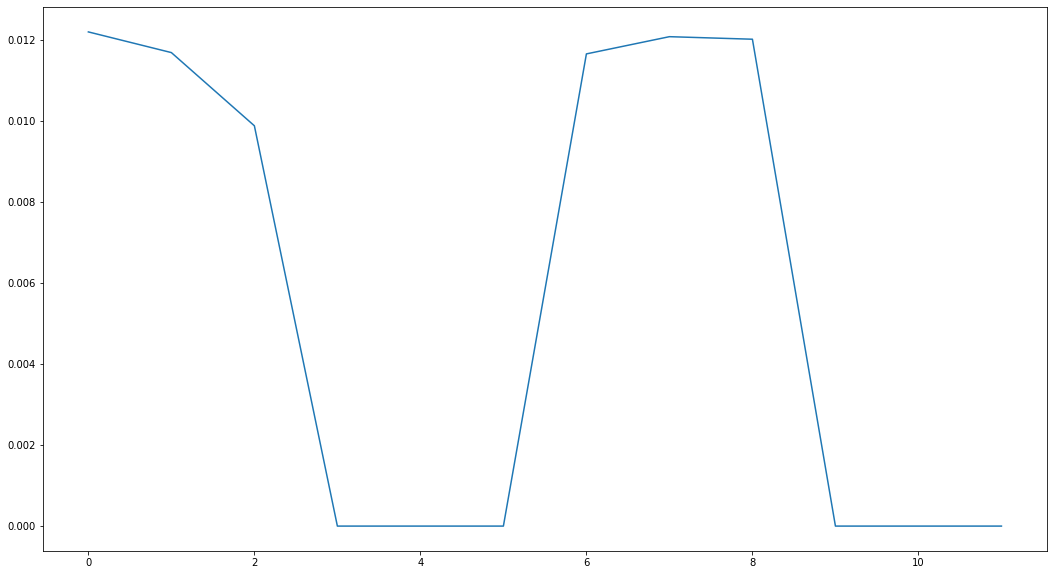

In [ ]:
model_loop = SelfNetClassifier(hparams=hparams)

trainer = pl.Trainer(gpus=1,
                    profiler="simple",
                    # precision=16,
                    max_epochs=2,
                    num_sanity_val_steps=0,
                    check_val_every_n_epoch=1,
                    checkpoint_callback=False, # Disable checkpoint saving.
                    overfit_batches=3)

trainer.fit(model_loop, train_dataloader, val_dataloader)

error_loop_mat = model_loop.model.loop_values
print(error_loop_mat)

plt.figure(figsize=(18, 10))
plt.plot(error_loop_mat)
plt.show()

del model_loop, trainer # Para não ter estouro de mémoria da GPU
torch.cuda.empty_cache()

# Overfitting em poucos batches

In [ ]:
hparams['temperature'] = 100
hparams['loop'] = False

In [ ]:
model_batch = SelfNetClassifier(hparams=hparams)

trainer = pl.Trainer(gpus=1,
                    # precision=16,
                    max_epochs=100,
                    check_val_every_n_epoch=1,
                    checkpoint_callback=False, # Disable checkpoint saving.
                    overfit_batches=3)

trainer.fit(model_batch, train_dataloader, val_dataloader)

trainer.test(model_batch, test_dataloader)
del model_batch, trainer # Para não ter estouro de mémoria da GPU
torch.cuda.empty_cache()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


using positional_embedding_type: embed
using max_position_embeddings: 1024



  | Name  | Type            | Params
------------------------------------------
0 | model | SelfAttentionNN | 120 M 
------------------------------------------
120 M     Trainable params
0         Non-trainable params
120 M     Total params
481.354   Total estimated model params size (MB)
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: You requested to overfit but enabled test/val dataloader shuffling. We are turning it off for you.
  warnings.warn(*args, **kwargs)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: You requested to overfit but enabled training dataloader shuffling. We are turning it off for you.
  warnings.warn(*args, **kwargs)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 1.0,
 'test_acc_step': 1.0,
 'test_f1': 1.0,
 'test_f1_step': 1.0,
 'test_loss': 0.0930851548910141,
 'test_loss_step': 0.0930851474404335}
--------------------------------------------------------------------------------


# Criando o classificador e treinamento

In [ ]:
pl_model =  SelfNetClassifier(hparams=hparams)

checkpoint_path = '/content/drive/MyDrive/aula10_checkpoints_AP/'
print(f'Files in {checkpoint_path}: {os.listdir(checkpoint_path)}')
print(f'Saving checkpoints to {checkpoint_path}')
checkpoint_callback = pl.callbacks.ModelCheckpoint(filename=hparams["version"]+'-{epoch:02d}-{val_f1:.2f}',
                                                    dirpath=checkpoint_path,
                                                    save_top_k=1, 
                                                    verbose=True,
                                                    monitor="val_f1", mode="max")
early_stop_callback = pl.callbacks.EarlyStopping(monitor='val_f1', patience=hparams["patience"], mode='max')
lr_monitor = pl.callbacks.LearningRateMonitor(logging_interval='epoch')

trainer = pl.Trainer(gpus=1, 
                     # precision=16,
                     logger=neptune_logger,
                     num_sanity_val_steps=0,
                     accumulate_grad_batches=hparams["accum_grads"],
                     checkpoint_callback=checkpoint_callback, 
                     callbacks=[early_stop_callback, lr_monitor],
                     max_epochs=hparams["max_epochs"])

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:68: UserWarning: Checkpoint directory /content/drive/MyDrive/aula10_checkpoints_AP/ exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores


using positional_embedding_type: embed
using max_position_embeddings: 1024
Files in /content/drive/MyDrive/aula10_checkpoints_AP/: ['selfatt_noposembed_test1-epoch=30-val_f1=0.79.ckpt', 'selfatt_noposembed_test2-epoch=00-val_f1=0.37.ckpt', 'selfatt_noposembed_test3-epoch=18-val_f1=0.85.ckpt', 'selfatt_noposembed_test4-epoch=46-val_f1=0.84.ckpt', 'selfatt_noposembed_test5-epoch=19-val_f1=0.84.ckpt', 'large_selfatt_sin_posembed_test1-epoch=00-val_f1=0.34.ckpt', 'large_selfatt_sin_posembed_test1-epoch=10-val_f1=0.82.ckpt', 'large_selfatt_sin_posembed_test2-epoch=03-val_f1=0.34.ckpt', 'large_selfatt_embed_posembed_test1-epoch=47-val_f1=0.85.ckpt']
Saving checkpoints to /content/drive/MyDrive/aula10_checkpoints_AP/


In [ ]:
trainer.fit(pl_model, train_dataloader, val_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


https://app.neptune.ai/orllem/Aula10Imdb/e/AUL6-78



  | Name  | Type            | Params
------------------------------------------
0 | model | SelfAttentionNN | 120 M 
------------------------------------------
120 M     Trainable params
0         Non-trainable params
120 M     Total params
481.354   Total estimated model params size (MB)


Epoch 0, global step 332: val_f1 reached 0.58842 (best 0.58842), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=00-val_f1=0.59.ckpt" as top 1


Epoch 1, global step 665: val_f1 reached 0.82409 (best 0.82409), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=01-val_f1=0.82.ckpt" as top 1


Epoch 2, global step 998: val_f1 reached 0.83398 (best 0.83398), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=02-val_f1=0.83.ckpt" as top 1


Epoch 3, step 1331: val_f1 was not in top 1


Epoch 4, step 1664: val_f1 was not in top 1


Epoch 5, step 1997: val_f1 was not in top 1


Epoch 6, step 2330: val_f1 was not in top 1


Epoch 7, global step 2663: val_f1 reached 0.83859 (best 0.83859), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=07-val_f1=0.84.ckpt" as top 1


Epoch 8, global step 2996: val_f1 reached 0.84723 (best 0.84723), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=08-val_f1=0.85.ckpt" as top 1


Epoch 9, global step 3329: val_f1 reached 0.84929 (best 0.84929), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=09-val_f1=0.85.ckpt" as top 1


Epoch 10, step 3662: val_f1 was not in top 1


Epoch 11, step 3995: val_f1 was not in top 1


Epoch 12, step 4328: val_f1 was not in top 1


Epoch 13, step 4661: val_f1 was not in top 1


Epoch 14, step 4994: val_f1 was not in top 1


Epoch 15, global step 5327: val_f1 reached 0.84992 (best 0.84992), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=15-val_f1=0.85.ckpt" as top 1


Epoch 16, step 5660: val_f1 was not in top 1


Epoch 17, global step 5993: val_f1 reached 0.85023 (best 0.85023), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=17-val_f1=0.85.ckpt" as top 1


Epoch 18, global step 6326: val_f1 reached 0.85654 (best 0.85654), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=18-val_f1=0.86.ckpt" as top 1


Epoch 19, step 6659: val_f1 was not in top 1


Epoch 20, step 6992: val_f1 was not in top 1


Epoch 21, global step 7325: val_f1 reached 0.85794 (best 0.85794), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=21-val_f1=0.86.ckpt" as top 1


Epoch 22, global step 7658: val_f1 reached 0.86053 (best 0.86053), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=22-val_f1=0.86.ckpt" as top 1


Epoch 23, global step 7991: val_f1 reached 0.86103 (best 0.86103), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=23-val_f1=0.86.ckpt" as top 1


Epoch 24, step 8324: val_f1 was not in top 1


Epoch 25, global step 8657: val_f1 reached 0.86252 (best 0.86252), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=25-val_f1=0.86.ckpt" as top 1


Epoch 26, step 8990: val_f1 was not in top 1


Epoch 27, step 9323: val_f1 was not in top 1


Epoch 28, global step 9656: val_f1 reached 0.86641 (best 0.86641), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=28-val_f1=0.87.ckpt" as top 1


Epoch 29, step 9989: val_f1 was not in top 1


Epoch 30, step 10322: val_f1 was not in top 1


Epoch 31, step 10655: val_f1 was not in top 1


Epoch 32, global step 10988: val_f1 reached 0.86916 (best 0.86916), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=32-val_f1=0.87.ckpt" as top 1


Epoch 33, global step 11321: val_f1 reached 0.87006 (best 0.87006), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=33-val_f1=0.87.ckpt" as top 1


Epoch 34, step 11654: val_f1 was not in top 1


Epoch 35, global step 11987: val_f1 reached 0.87162 (best 0.87162), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=35-val_f1=0.87.ckpt" as top 1


Epoch 36, step 12320: val_f1 was not in top 1


Epoch 37, global step 12653: val_f1 reached 0.87483 (best 0.87483), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=37-val_f1=0.87.ckpt" as top 1


Epoch 38, step 12986: val_f1 was not in top 1


Epoch 39, global step 13319: val_f1 reached 0.87587 (best 0.87587), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=39-val_f1=0.88.ckpt" as top 1


Epoch 40, step 13652: val_f1 was not in top 1


Epoch 41, step 13985: val_f1 was not in top 1


Epoch 42, step 14318: val_f1 was not in top 1


Epoch 43, step 14651: val_f1 was not in top 1


Epoch 44, global step 14984: val_f1 reached 0.87641 (best 0.87641), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=44-val_f1=0.88.ckpt" as top 1


Epoch 45, global step 15317: val_f1 reached 0.87751 (best 0.87751), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=45-val_f1=0.88.ckpt" as top 1


Epoch 46, step 15650: val_f1 was not in top 1


Epoch 47, step 15983: val_f1 was not in top 1


Epoch 48, step 16316: val_f1 was not in top 1


Epoch 49, step 16649: val_f1 was not in top 1


Epoch 50, global step 16982: val_f1 reached 0.87829 (best 0.87829), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=50-val_f1=0.88.ckpt" as top 1


Epoch 51, global step 17315: val_f1 reached 0.87993 (best 0.87993), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=51-val_f1=0.88.ckpt" as top 1


Epoch 52, step 17648: val_f1 was not in top 1


Epoch 53, step 17981: val_f1 was not in top 1


Epoch 54, step 18314: val_f1 was not in top 1


Epoch 55, step 18647: val_f1 was not in top 1


Epoch 56, global step 18980: val_f1 reached 0.88223 (best 0.88223), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=56-val_f1=0.88.ckpt" as top 1


Epoch 57, step 19313: val_f1 was not in top 1


Epoch 58, step 19646: val_f1 was not in top 1


Epoch 59, step 19979: val_f1 was not in top 1


Epoch 60, step 20312: val_f1 was not in top 1


Epoch 61, global step 20645: val_f1 reached 0.88286 (best 0.88286), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=61-val_f1=0.88.ckpt" as top 1


Epoch 62, step 20978: val_f1 was not in top 1


Epoch 63, step 21311: val_f1 was not in top 1


Epoch 64, global step 21644: val_f1 reached 0.88393 (best 0.88393), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=64-val_f1=0.88.ckpt" as top 1


Epoch 65, step 21977: val_f1 was not in top 1


Epoch 66, step 22310: val_f1 was not in top 1


Epoch 67, step 22643: val_f1 was not in top 1


Epoch 68, step 22976: val_f1 was not in top 1


Epoch 69, step 23309: val_f1 was not in top 1


Epoch 70, step 23642: val_f1 was not in top 1


Epoch 71, step 23975: val_f1 was not in top 1


Epoch 72, step 24308: val_f1 was not in top 1


Epoch 73, step 24641: val_f1 was not in top 1


Epoch 74, step 24974: val_f1 was not in top 1


Epoch 75, step 25307: val_f1 was not in top 1


Epoch 76, step 25640: val_f1 was not in top 1


Epoch 77, global step 25973: val_f1 reached 0.88394 (best 0.88394), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=77-val_f1=0.88.ckpt" as top 1


Epoch 78, step 26306: val_f1 was not in top 1


Epoch 79, global step 26639: val_f1 reached 0.88528 (best 0.88528), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=79-val_f1=0.89.ckpt" as top 1


Epoch 80, step 26972: val_f1 was not in top 1


Epoch 81, global step 27305: val_f1 reached 0.88660 (best 0.88660), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=81-val_f1=0.89.ckpt" as top 1


Epoch 82, step 27638: val_f1 was not in top 1


Epoch 83, step 27971: val_f1 was not in top 1


Epoch 84, step 28304: val_f1 was not in top 1


Epoch 85, step 28637: val_f1 was not in top 1


Epoch 86, step 28970: val_f1 was not in top 1


Epoch 87, step 29303: val_f1 was not in top 1


Epoch 88, global step 29636: val_f1 reached 0.88697 (best 0.88697), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=88-val_f1=0.89.ckpt" as top 1


Epoch 89, step 29969: val_f1 was not in top 1


Epoch 90, step 30302: val_f1 was not in top 1


Epoch 91, global step 30635: val_f1 reached 0.88716 (best 0.88716), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=91-val_f1=0.89.ckpt" as top 1


Epoch 92, step 30968: val_f1 was not in top 1


Epoch 93, global step 31301: val_f1 reached 0.88751 (best 0.88751), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=93-val_f1=0.89.ckpt" as top 1


Epoch 94, global step 31634: val_f1 reached 0.88828 (best 0.88828), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=94-val_f1=0.89.ckpt" as top 1


Epoch 95, step 31967: val_f1 was not in top 1


Epoch 96, step 32300: val_f1 was not in top 1


Epoch 97, global step 32633: val_f1 reached 0.88898 (best 0.88898), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=97-val_f1=0.89.ckpt" as top 1


Epoch 98, global step 32966: val_f1 reached 0.89006 (best 0.89006), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=98-val_f1=0.89.ckpt" as top 1


Epoch 99, step 33299: val_f1 was not in top 1


Epoch 100, step 33632: val_f1 was not in top 1


Epoch 101, step 33965: val_f1 was not in top 1


Epoch 102, step 34298: val_f1 was not in top 1


Epoch 103, step 34631: val_f1 was not in top 1


Epoch 104, step 34964: val_f1 was not in top 1


Epoch 105, step 35297: val_f1 was not in top 1


Epoch 106, step 35630: val_f1 was not in top 1


Epoch 107, step 35963: val_f1 was not in top 1


Epoch 108, step 36296: val_f1 was not in top 1


Epoch 109, global step 36629: val_f1 reached 0.89034 (best 0.89034), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=109-val_f1=0.89.ckpt" as top 1


Epoch 110, global step 36962: val_f1 reached 0.89123 (best 0.89123), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=110-val_f1=0.89.ckpt" as top 1


Epoch 111, step 37295: val_f1 was not in top 1


Epoch 112, step 37628: val_f1 was not in top 1


Epoch 113, step 37961: val_f1 was not in top 1


Epoch 114, step 38294: val_f1 was not in top 1


Epoch 115, step 38627: val_f1 was not in top 1


Epoch 116, step 38960: val_f1 was not in top 1


Epoch 117, step 39293: val_f1 was not in top 1


Epoch 118, step 39626: val_f1 was not in top 1


Epoch 119, global step 39959: val_f1 reached 0.89131 (best 0.89131), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=119-val_f1=0.89.ckpt" as top 1


Epoch 120, step 40292: val_f1 was not in top 1


Epoch 121, step 40625: val_f1 was not in top 1


Epoch 122, step 40958: val_f1 was not in top 1


Epoch 123, step 41291: val_f1 was not in top 1


Epoch 124, global step 41624: val_f1 reached 0.89138 (best 0.89138), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=124-val_f1=0.89.ckpt" as top 1


Epoch 125, step 41957: val_f1 was not in top 1


Epoch 126, step 42290: val_f1 was not in top 1


Epoch 127, step 42623: val_f1 was not in top 1


Epoch 128, global step 42956: val_f1 reached 0.89166 (best 0.89166), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=128-val_f1=0.89.ckpt" as top 1


Epoch 129, global step 43289: val_f1 reached 0.89192 (best 0.89192), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=129-val_f1=0.89.ckpt" as top 1


Epoch 130, step 43622: val_f1 was not in top 1


Epoch 131, global step 43955: val_f1 reached 0.89210 (best 0.89210), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=131-val_f1=0.89.ckpt" as top 1


Epoch 132, step 44288: val_f1 was not in top 1


Epoch 133, step 44621: val_f1 was not in top 1


Epoch 134, step 44954: val_f1 was not in top 1


Epoch 135, step 45287: val_f1 was not in top 1


Epoch 136, step 45620: val_f1 was not in top 1


Epoch 137, step 45953: val_f1 was not in top 1


Epoch 138, step 46286: val_f1 was not in top 1


Epoch 139, step 46619: val_f1 was not in top 1


Epoch 140, global step 46952: val_f1 reached 0.89263 (best 0.89263), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=140-val_f1=0.89.ckpt" as top 1


Epoch 141, global step 47285: val_f1 reached 0.89271 (best 0.89271), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=141-val_f1=0.89.ckpt" as top 1


Epoch 142, step 47618: val_f1 was not in top 1


Epoch 143, step 47951: val_f1 was not in top 1


Epoch 144, step 48284: val_f1 was not in top 1


Epoch 145, global step 48617: val_f1 reached 0.89271 (best 0.89271), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=145-val_f1=0.89.ckpt" as top 1


Epoch 146, step 48950: val_f1 was not in top 1


Epoch 147, step 49283: val_f1 was not in top 1


Epoch 148, step 49616: val_f1 was not in top 1


Epoch 149, step 49949: val_f1 was not in top 1


Epoch 150, global step 50282: val_f1 reached 0.89298 (best 0.89298), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=150-val_f1=0.89.ckpt" as top 1


Epoch 151, step 50615: val_f1 was not in top 1


Epoch 152, step 50948: val_f1 was not in top 1


Epoch 153, step 51281: val_f1 was not in top 1


Epoch 154, step 51614: val_f1 was not in top 1


Epoch 155, step 51947: val_f1 was not in top 1


Epoch 156, step 52280: val_f1 was not in top 1


Epoch 157, step 52613: val_f1 was not in top 1


Epoch 158, step 52946: val_f1 was not in top 1


Epoch 159, global step 53279: val_f1 reached 0.89322 (best 0.89322), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=159-val_f1=0.89.ckpt" as top 1


Epoch 160, step 53612: val_f1 was not in top 1


Epoch 161, global step 53945: val_f1 reached 0.89348 (best 0.89348), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=161-val_f1=0.89.ckpt" as top 1


Epoch 162, global step 54278: val_f1 reached 0.89375 (best 0.89375), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=162-val_f1=0.89.ckpt" as top 1


Epoch 163, step 54611: val_f1 was not in top 1


Epoch 164, global step 54944: val_f1 reached 0.89400 (best 0.89400), saving model to "/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=164-val_f1=0.89.ckpt" as top 1


Epoch 165, step 55277: val_f1 was not in top 1


Epoch 166, step 55610: val_f1 was not in top 1


Epoch 167, step 55943: val_f1 was not in top 1


Epoch 168, step 56276: val_f1 was not in top 1


Epoch 169, step 56609: val_f1 was not in top 1


Epoch 170, step 56942: val_f1 was not in top 1


Epoch 171, step 57275: val_f1 was not in top 1


Epoch 172, step 57608: val_f1 was not in top 1


Epoch 173, step 57941: val_f1 was not in top 1


Epoch 174, step 58274: val_f1 was not in top 1


Epoch 175, step 58607: val_f1 was not in top 1


Epoch 176, step 58940: val_f1 was not in top 1


Epoch 177, step 59273: val_f1 was not in top 1


Epoch 178, step 59606: val_f1 was not in top 1


Epoch 179, step 59939: val_f1 was not in top 1


Epoch 180, step 60272: val_f1 was not in top 1


Epoch 181, step 60605: val_f1 was not in top 1


Epoch 182, step 60938: val_f1 was not in top 1


Epoch 183, step 61271: val_f1 was not in top 1


Epoch 184, step 61604: val_f1 was not in top 1


Epoch 185, step 61937: val_f1 was not in top 1


Epoch 186, step 62270: val_f1 was not in top 1


Epoch 187, step 62603: val_f1 was not in top 1


Epoch 188, step 62936: val_f1 was not in top 1


Epoch 189, step 63269: val_f1 was not in top 1


Epoch 190, step 63602: val_f1 was not in top 1


Epoch 191, step 63935: val_f1 was not in top 1


Epoch 192, step 64268: val_f1 was not in top 1


Epoch 193, step 64601: val_f1 was not in top 1


Epoch 194, step 64934: val_f1 was not in top 1


Epoch 195, step 65267: val_f1 was not in top 1


Epoch 196, step 65600: val_f1 was not in top 1


Epoch 197, step 65933: val_f1 was not in top 1


Epoch 198, step 66266: val_f1 was not in top 1


Epoch 199, step 66599: val_f1 was not in top 1


1

## Teste - Avaliação do classificador 


In [ ]:
from sklearn import metrics

In [ ]:
# best_model = checkpoint_callback.best_model_path
best_model = '/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=164-val_f1=0.89.ckpt'
print(best_model)
test_model = SelfNetClassifier.load_from_checkpoint(best_model, hparams=hparams).cuda().eval()

/content/drive/MyDrive/aula10_checkpoints_AP/large_selfatt_embed_posembed_test2-epoch=164-val_f1=0.89.ckpt
using positional_embedding_type: embed
using max_position_embeddings: 1024


In [ ]:
trainer.test(test_model, test_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.953125,
 'test_acc_step': 0.9399999976158142,
 'test_f1': 0.9530630111694336,
 'test_f1_step': 0.9399206638336182,
 'test_loss': 0.1789875626564026,
 'test_loss_step': 0.19431456923484802}
--------------------------------------------------------------------------------


[{'test_acc': 0.953125,
  'test_acc_step': 0.9399999976158142,
  'test_f1': 0.9530630111694336,
  'test_f1_step': 0.9399206638336182,
  'test_loss': 0.1789875626564026,
  'test_loss_step': 0.19431456923484802}]

In [ ]:
y_true = list()
y_pred = list()

with torch.no_grad():
  for batch in test_dataloader:
    x, mask, y = batch
    logits = test_model(x.cuda(), mask.cuda())
    preds = torch.argmax(logits, dim=1)    
    
    y_true.append(y.cpu().numpy())
    y_pred.append(preds.cpu().numpy())

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

In [ ]:
# f1 score (hard-majority vote)
print('f1:', metrics.f1_score(y_true, y_pred, average='weighted'))

# accuracy
print('acc:', metrics.accuracy_score(y_true, y_pred))

# balanced accuracy
print('balanced acc:', metrics.balanced_accuracy_score(y_true, y_pred))

f1: 0.9248202527813517
acc: 0.925
balanced acc: 0.9228720731584765


In [ ]:
print('classification report:', metrics.classification_report(y_true, y_pred))

classification report:               precision    recall  f1-score   support

           0       0.91      0.95      0.93       107
           1       0.94      0.89      0.92        93

    accuracy                           0.93       200
   macro avg       0.93      0.92      0.92       200
weighted avg       0.93      0.93      0.92       200

